In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor



In [2]:
def get_data():

    train_data_path = r'train.csv'
    train = pd.read_csv(train_data_path)

    test_data_path = r'test.csv'
    test = pd.read_csv(test_data_path)

    return train, test


def get_combined_data():

    train, test = get_data()

    target = train.SalePrice
    train.drop(['SalePrice'], axis=1, inplace=True)

    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'Id'], inplace=True, axis=1)

    return combined, target

train_data, test_data = get_data()

combined, target = get_combined_data()

In [3]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [4]:
def get_cols_with_no_nans(df, col_type):
    if col_type == 'num':
        predictors = df.select_dtypes(exclude=['object'])
    elif col_type == 'no_num':
        predictors = df.select_dtypes(exclude=['object'])
    elif col_type == 'all':
        predictors = df
    else:
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [5]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 25


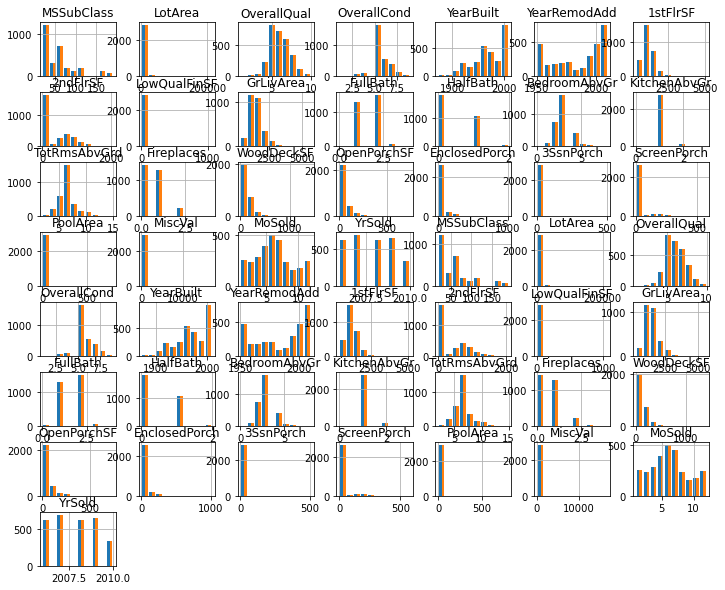

In [6]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize=(12, 10))
plt.show()

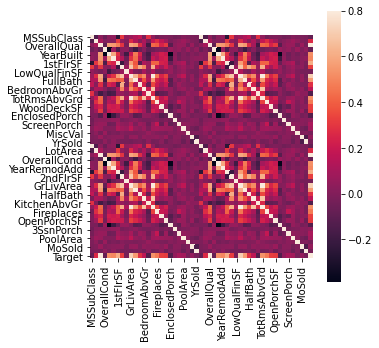

In [7]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [8]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if(df[col].dtypes is np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))


There were 50 columns before encoding categorical features
There are 50 columns after encoding categorical features


In [9]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train, test = split_combined()

In [10]:
model = Sequential()

model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

model.add(Dense(1, kernel_initializer='normal',activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 171,393
Trainable params: 171,393
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(train, target, epochs=100, batch_size=300, validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 0s 16ms/step - loss: 15150.6699 - mean_absolute_error: 15150.6699 - val_loss: 24101.5312 - val_mean_absolute_error: 24101.5312
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 14273.2461 - mean_absolute_error: 14273.2461 - val_loss: 24353.4297 - val_mean_absolute_error: 24353.4297
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 13377.6924 - mean_absolute_error: 13377.6924 - val_loss: 22905.6660 - val_mean_absolute_error: 22905.6660
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 12779.8584 - mean_absolute_error: 12779.8584 - val_loss: 22547.7285 - val_mean_absolute_error: 22547.7285
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 12554.7666 - mean_absolute_error: 12554.7656 - val_loss: 22559.5547 - val_mean_absolute_error: 22559.5547
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 12123.3223 - mean_absolute_error: 12123.322

In [24]:
model.save('housing_predict_dnn.h5')

<function matplotlib.pyplot.show(close=None, block=None)>

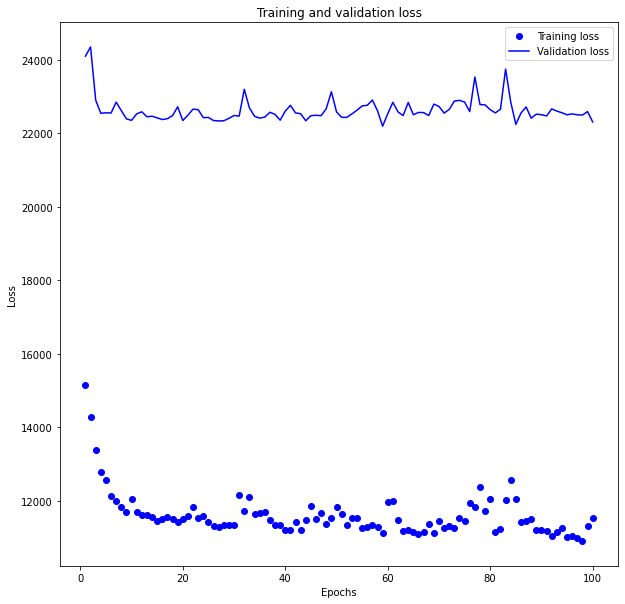

In [25]:
history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']

epochs = range(1, len(loss_value)+1)

plt.figure(figsize=(10, 10))
plt.plot(epochs, loss_value, 'bo', label='Training loss')
plt.plot(epochs, val_loss_value, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show

<Figure size 432x288 with 0 Axes>

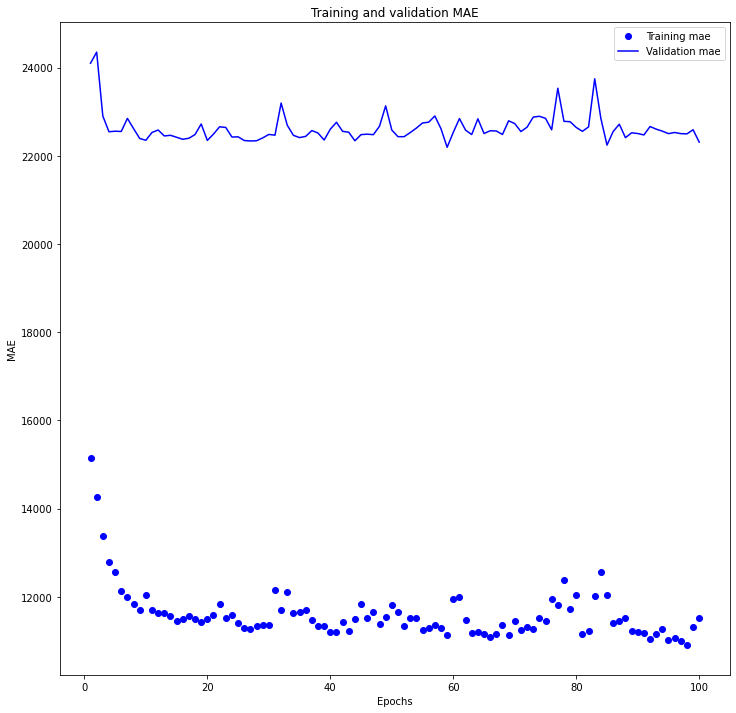

In [26]:
plt.clf()
mae = history_dict['mean_absolute_error']
val_mae = history_dict['val_mean_absolute_error']

plt.figure(figsize=(12, 12))
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [ ]:
def make_submission(prediction, sub_name):
    my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
    my_submission.to_csv('{}.csv'.format(sub_name),index=False)
    print('A submission file has been made')

predictions = model.predict(test)
make_submission(predictions[:,0],'submission(NN).csv')